In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.transform import Rotation
import cv2
import pandas as pd
import plotly.graph_objects as go


In [126]:
K = [ 909.95300569, 0., 635.79822139, 0., 909.95300569, 385.66617804, 0., 0., 1. ]
K = np.array(K).reshape(3, 3)

In [127]:
MOCK_DATA = True

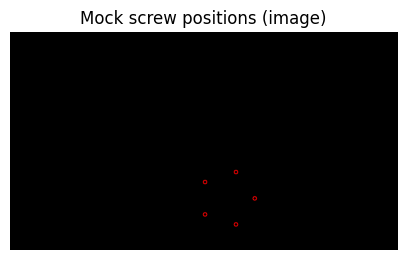

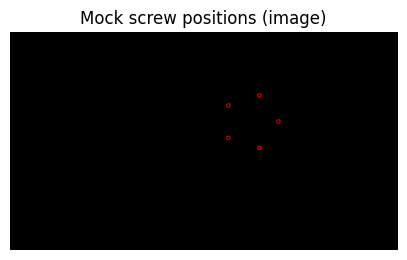

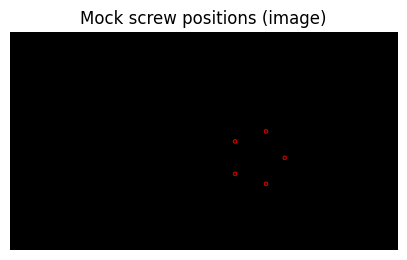

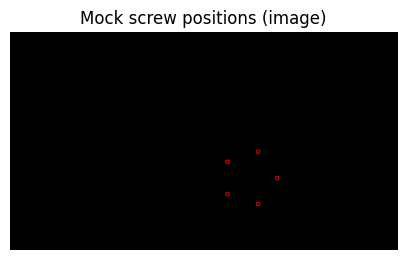

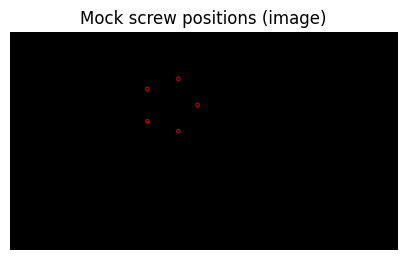

In [128]:
if MOCK_DATA:
    # Generate mock data
    screw_center = np.array([1, 0, 0])
    screw_circle_radius = 0.05
    num_screws = 5
    screw_positions = []
    for i in range(num_screws):
        ang = i * 2*np.pi / num_screws
        screw_positions.append(screw_center + np.array([screw_circle_radius*np.cos(ang), screw_circle_radius*np.sin(ang), 0]))
    mock_screw_positions = np.stack(screw_positions)

    # Mock poses
    num_pictures = 5
    cam_base_pos = [1, 0, 0.5]
    cam_rot = Rotation.from_euler("xyz",[180, 0, 0],degrees=True).as_matrix()
    poses = np.stack([np.eye(4) for i in range(num_screws)])
    for i in range(num_pictures):
        rand_ang = np.random.random()*2*np.pi
        rand_rotm = np.array([[np.cos(rand_ang), np.sin(rand_ang)],[-np.sin(rand_ang), np.cos(rand_ang)]])
        cam_pos_deviation = np.dot(rand_rotm,np.array([0,1]))
        cam_pos_deviation = 0.1*np.array([*cam_pos_deviation, 0])
        poses[i][:3,3] = cam_base_pos
        poses[i][:3,3] += cam_pos_deviation
        poses[i][:3,:3] = cam_rot
    # Pose given as cam2world

    # Mock detections
    detections = np.zeros((num_pictures, num_screws, 2))
    for i in range(num_pictures):
        cam_pose = poses[i]
        screw_positions_img = np.zeros((num_screws,2))
        for j in range(num_screws):
            screw_position_world_hom = np.hstack([mock_screw_positions[j],1])
            screw_position_cam_hom = np.dot(np.linalg.inv(cam_pose), screw_position_world_hom)
            screw_position_cam = screw_position_cam_hom[:3] / screw_position_cam_hom[-1]
            screw_position_img_hom = np.dot(K, screw_position_cam)
            screw_positions_img[j,:] = screw_position_img_hom[:2] / screw_position_img_hom[-1]
        img = np.zeros((720, 1280, 3), dtype=np.uint8)
        for (u, v) in screw_positions_img:
            u_i, v_i = int(round(u)), int(round(v))
            if 0 <= u_i < img.shape[1] and 0 <= v_i < img.shape[0]:
                cv2.circle(img, (u_i, v_i), radius=6, color=(0, 0, 255), thickness=2)
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Mock screw positions (image)")
        plt.show()

        detections[i, :] = screw_positions_img

    poses = np.repeat(poses,num_screws,axis=0)
    poses = [poses[i] for i in range(poses.shape[0])]
    img = np.repeat(list(range(num_pictures)),num_screws,axis=0)
    x = detections[:,:,0].flatten()
    y = detections[:,:,1].flatten()
    data = {
        "img": img,
        "pose": poses,
        "x": x,
        "y": y
    }

In [129]:
if not MOCK_DATA:
    # Open collected data
    with open("data/20260213_171657/_screw_detections.csv", "r") as f:
        data = f.read().splitlines()
        headers = data[0].split(",")
        data = data[1:]  # Remove header
        data_dict = {header: [] for header in headers}
        for row in data:
            values = row.split(",")
            for header, value in zip(headers, values):
                data_dict[header].append(value)
    # Make pose into TF matrices
    poses = data_dict["pose"]
    for i in range(len(poses)):
        pose = poses[i]
        pose = [float(x.split(">")[1]) for x in pose.split(";")]
        pos =  pose[:3]
        quat = pose[3:]
        matrix = np.eye(4)
        matrix[:3, 3] = pos
        matrix[:3, :3] = Rotation.from_quat(quat).as_matrix()
        data_dict["pose"][i] = matrix
    data = data_dict
    timestamps = np.unique(data["timestamp"])
    timestamp_ids = {timestamp: i for i, timestamp in enumerate(timestamps)}
    data["img"] = [timestamp_ids[t] for t in data["timestamp"]]

In [130]:
data["ray_origin"] = []
data["ray_direction"] = []
data["ray_num"] = []

ray_idx = 0
last_img_idx = 0
for img_idx, u, v, pose in zip(data["img"], data["x"], data["y"], data["pose"]):
    u = float(u)
    v = float(v)
    pixel_homogeneous = np.array([u, v, 1.0])
    ray_direction = np.linalg.inv(K) @ pixel_homogeneous
    ray_direction /= np.linalg.norm(ray_direction)  # Normalize the direction
    camera2world_pose = pose
    world2camera_pose = np.linalg.inv(camera2world_pose)
    camear2world_rot = Rotation.from_matrix(camera2world_pose[:3,:3])

    ray_direction_rot = camear2world_rot.apply(ray_direction)
    ray_origin = camera2world_pose[:3, 3]  # Extract the translation part of the pose
    data["ray_origin"].append(ray_origin)
    data["ray_direction"].append(ray_direction_rot)

    if img_idx == last_img_idx:
        data["ray_num"].append(ray_idx)
        ray_idx += 1
    else:
        ray_idx = 0
        data["ray_num"].append(ray_idx)
        ray_idx += 1
        
    last_img_idx = img_idx

In [131]:
data = pd.DataFrame.from_dict(data)
data

,img,pose,x,y,ray_origin,ray_direction,ray_num
0,0,"[[1.0, 0.0, 0.0, 0.9556888223633537], [0.0, -1...",807.435701,548.814632,"[0.9556888223633537, 0.08964663706159637, 0.5]","[0.18254231975922827, -0.17351395134608893, -0...",0
1,0,"[[1.0, 0.0, 0.0, 0.9556888223633537], [0.0, -1...",744.559494,462.272958,"[0.9556888223633537, 0.08964663706159637, 0.5]","[0.118266845462794, -0.08330209817121592, -0.9...",1
2,0,"[[1.0, 0.0, 0.0, 0.9556888223633537], [0.0, -1...",642.823655,495.328936,"[0.9556888223633537, 0.08964663706159637, 0.5]","[0.007664967438880628, -0.11964548683725851, -...",2
3,0,"[[1.0, 0.0, 0.0, 0.9556888223633537], [0.0, -1...",642.823655,602.300327,"[0.9556888223633537, 0.08964663706159637, 0.5]","[0.007510529806693871, -0.2315924169134972, -0...",3
4,0,"[[1.0, 0.0, 0.0, 0.9556888223633537], [0.0, -1...",744.559494,635.356305,"[0.9556888223633537, 0.08964663706159637, 0.5]","[0.11450530364051725, -0.26287706175943387, -0...",4
5,1,"[[1.0, 0.0, 0.0, 0.9132145328007004], [0.0, -1...",884.734915,295.249945,"[0.9132145328007004, -0.04968181440929161, 0.5]","[0.2626711005074781, 0.09540470295051733, -0.9...",0
6,1,"[[1.0, 0.0, 0.0, 0.9132145328007004], [0.0, -1...",821.858709,208.708272,"[0.9132145328007004, -0.04968181440929161, 0.5]","[0.1967878362089981, 0.1871604438723026, -0.96...",1
7,1,"[[1.0, 0.0, 0.0, 0.9132145328007004], [0.0, -1...",720.122870,241.764250,"[0.9132145328007004, -0.04968181440929161, 0.5]","[0.0911507101952588, 0.15555075704809682, -0.9...",2
8,1,"[[1.0, 0.0, 0.0, 0.9132145328007004], [0.0, -1...",720.122870,348.735641,"[0.9132145328007004, -0.04968181440929161, 0.5]","[0.09219862169001238, 0.04037899539856678, -0....",3
9,1,"[[1.0, 0.0, 0.0, 0.9132145328007004], [0.0, -1...",821.858709,381.791619,"[0.9132145328007004, -0.04968181440929161, 0.5]","[0.20032601309737347, 0.00417162716664219, -0....",4


In [132]:
def plot_poses(poses, scale=0.05, axis_labels=True, ax=None, figsize=(8, 6)):
    """
    Visualize 4x4 pose matrices as coordinate frames using Plotly.
    - poses: single 4x4 array or iterable/array of shape (N,4,4)
    - scale: length of drawn axes
    - axis_labels: annotate axes ('x','y','z') for each pose
    - ax: ignored (kept for compatibility)
    Returns the plotly Figure.
    """
    poses = np.asarray(poses)
    if poses.ndim == 2 and poses.shape == (4, 4):
        poses = poses[None, ...]
    assert poses.ndim == 3 and poses.shape[1:] == (4, 4), "poses must be (N,4,4) or (4,4)"

    fig = go.Figure()
    all_points = []

    for i, pose in enumerate(poses):
        t = pose[:3, 3]
        R = pose[:3, :3]
        for vec, color, lbl in zip(R.T, ("red", "green", "blue"), ("x", "y", "z")):
            end = t + vec * scale
            line = np.vstack([t, end])
            fig.add_trace(go.Scatter3d(
                x=line[:, 0], y=line[:, 1], z=line[:, 2],
                mode="lines", line=dict(color=color, width=4), showlegend=False
            ))
            fig.add_trace(go.Scatter3d(
                x=[t[0]], y=[t[1]], z=[t[2]],
                mode="markers", marker=dict(color=color, size=4), showlegend=False
            ))
            if axis_labels:
                fig.add_trace(go.Scatter3d(
                    x=[end[0]], y=[end[1]], z=[end[2]],
                    mode="text", text=[f"{lbl}{i}"], textposition="top center",
                    showlegend=False
                ))
        all_points.extend([t, t + R[:, 0] * scale, t + R[:, 1] * scale, t + R[:, 2] * scale])

    all_points = np.vstack(all_points)
    mins = all_points.min(axis=0)
    maxs = all_points.max(axis=0)
    centers = 0.5 * (mins + maxs)
    radius = (maxs - mins).max() / 2.0

    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X", range=[centers[0] - radius, centers[0] + radius]),
            yaxis=dict(title="Y", range=[centers[1] - radius, centers[1] + radius]),
            zaxis=dict(title="Z", range=[centers[2] - radius, centers[2] + radius]),
        ),
        width=figsize[0] * 100,
        height=figsize[1] * 100,
    )
    # fig.show()
    return fig

plot_poses(np.stack(data["pose"].values))

In [133]:
img_indices = data["img"].unique()

# Choose only poses with large baseline
unique_img_poses = []
for img in img_indices:
    img_data = data[data["img"] == img]
    img_poses = np.stack(img_data["pose"].values)
    # Check that all detections of same image have same pose
    assert len(np.unique(img_poses,axis=0)) == 1, np.unique(img_poses,axis=0)
    img_pose = img_poses[0,...]
    unique_img_poses.append(img_pose)

camera_positions = np.stack(unique_img_poses)[:,:3,3]
pairwise_dists = np.linalg.norm(camera_positions[None,...]-camera_positions[:,None,...], axis=2)
max_pairwise_dists = np.argmax(pairwise_dists.ravel())
pairwise_dists
max_pair = np.unravel_index(max_pairwise_dists, pairwise_dists.shape)
camera_positions[max_pair[0]], camera_positions[max_pair[1]]

(array([0.95568882, 0.08964664, 0.5       ]),
 array([ 1.06004656, -0.07996506,  0.5       ]))

In [134]:
# # Select known subset
# img_subset = [0, 6, 14]
# data = data[data["img"].isin(img_subset)]
# img_indices = img_subset

In [135]:
def closest_point_between_rays(ray1_origin, ray1_direction, ray2_origin, ray2_direction):
    # Compute the cross product of the direction vectors
    cross = np.cross(ray1_direction, ray2_direction)
    denom = np.linalg.norm(cross) ** 2
    
    # If the rays are parallel (cross product is zero), return None
    if denom < 1e-6:
        return None
    
    # Compute the parameters for the closest points on each ray
    t1 = np.linalg.det([ray2_origin - ray1_origin, ray2_direction, cross]) / denom
    t2 = np.linalg.det([ray2_origin - ray1_origin, ray1_direction, cross]) / denom
    
    # Compute the closest points on each ray
    closest_point_ray1 = ray1_origin + t1 * ray1_direction
    closest_point_ray2 = ray2_origin + t2 * ray2_direction

    # Get the distance between the closest points
    distance = np.linalg.norm(closest_point_ray1 - closest_point_ray2)
    
    # Return the midpoint between the two closest points as the best estimate
    return (closest_point_ray1 + closest_point_ray2) / 2, distance

def distance_of_point_from_ray(point_3D, ray_origin, ray_direction):
    ray_to_point = point_3D - ray_origin
    ray_vector = np.dot(ray_to_point, ray_direction) * ray_direction
    perpendicular_vector = ray_to_point - ray_vector

    distance = np.linalg.norm(perpendicular_vector)
    return distance

In [136]:
def reprojection_error(point3D_hyp, point2D_meas, pose):
    point3D_hyp_hom = np.hstack((point3D_hyp, 1))
    point3D_hyp_hom = np.dot(pose, point3D_hyp_hom)
    point3D_hyp = point3D_hyp[:3] / point3D_hyp[-1]
    point2D_hyp = np.dot(K, point3D_hyp)
    point2D_hyp = point2D_hyp[:2] / point2D_hyp[-1]
    error = np.linalg.norm(point2D_hyp, point2D_meas)
    return error

Ray pairing between maximum distance images

In [137]:

# Visualize the rays and the closest point

def plot_rays(ray_origins, ray_directions, colors="red", name="ray"):
    if isinstance(colors, str):
        colors = [colors for i in range(ray_origins.shape[0])]
        print(colors)
    fig = go.Figure()
    for o, d, color in zip(ray_origins, ray_directions, colors):
        line = np.vstack([o, o + d])
        fig.add_trace(go.Scatter3d(
            x=line[:, 0], y=line[:, 1], z=line[:, 2],
            mode="lines", line=dict(color=color), name=name, showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[o[0]], y=[o[1]], z=[o[2]],
            mode="markers", marker=dict(color=color, size=4), showlegend=False
        ))
    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"))
    fig.show()

def plot_rays_and_points(ray_origins, ray_directions, points=None, colors="red", name="ray", point_color="green", point_size=6):
    if isinstance(colors, str):
        colors = [colors for _ in range(ray_origins.shape[0])]
    fig = go.Figure()
    for o, d, color in zip(ray_origins, ray_directions, colors):
        line = np.vstack([o, o + d])
        fig.add_trace(go.Scatter3d(
            x=line[:, 0], y=line[:, 1], z=line[:, 2],
            mode="lines", line=dict(color=color), name=name, showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[o[0]], y=[o[1]], z=[o[2]],
            mode="markers", marker=dict(color=color, size=4), showlegend=False
        ))
    if points is not None:
        points = np.asarray(points)
        fig.add_trace(go.Scatter3d(
            x=points[:, 0], y=points[:, 1], z=points[:, 2],
            mode="markers", marker=dict(color=point_color, size=point_size), name="points", showlegend=False
        ))
    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"))
    fig.show()

def plot_two_rays_with_closest(ray_o1, ray_d1, ray_o2, ray_d2, closest_point):
    ray1_line = np.vstack([ray_o1, ray_o1 + ray_d1])
    ray2_line = np.vstack([ray_o2, ray_o2 + ray_d2])

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=ray1_line[:, 0], y=ray1_line[:, 1], z=ray1_line[:, 2],
                               mode="lines", line=dict(color="red"), name="ray1"))
    fig.add_trace(go.Scatter3d(x=ray2_line[:, 0], y=ray2_line[:, 1], z=ray2_line[:, 2],
                               mode="lines", line=dict(color="blue"), name="ray2"))
    fig.add_trace(go.Scatter3d(x=[ray_o1[0]], y=[ray_o1[1]], z=[ray_o1[2]],
                               mode="markers", marker=dict(color="red", size=5), name="ray1_origin"))
    fig.add_trace(go.Scatter3d(x=[ray_o2[0]], y=[ray_o2[1]], z=[ray_o2[2]],
                               mode="markers", marker=dict(color="blue", size=5), name="ray2_origin"))
    fig.add_trace(go.Scatter3d(x=[closest_point[0]], y=[closest_point[1]], z=[closest_point[2]],
                               mode="markers", marker=dict(color="green", size=6), name="closest_point"))
    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"))
    fig.show()


In [138]:
img_data1 = data[data["img"] == np.random.choice(img_indices)]
img_data2 = data[data["img"] == np.random.choice(img_indices)]

closest_points = {}
for idx1, detection1 in img_data1.iterrows():
    ray_o1 = detection1["ray_origin"]
    ray_d1 = detection1["ray_direction"]

    for idx2, detection2 in img_data2[["ray_origin", "ray_direction"]].iterrows():
        ray_o2 = detection2["ray_origin"]
        ray_d2 = detection2["ray_direction"]

        closest_point, distance = closest_point_between_rays(
            np.array(ray_o1),
            np.array(ray_d1),
            np.array(ray_o2),
            np.array(ray_d2),
        )
        closest_points[(idx1, idx2)] = (closest_point, distance)

plot_two_rays_with_closest(ray_o1, ray_d1, ray_o2, ray_d2, closest_point)
closest_point

array([ 1.01545085e+00, -4.75528258e-02,  1.11022302e-16])

In [139]:
cmap = plt.get_cmap()
colors = cmap(data["img"]/max(data["img"]))
all_ray_origins = np.concatenate([data["ray_origin"].to_list()])
all_ray_directions = np.concatenate([data["ray_direction"].to_list()])

plot_rays(
    all_ray_origins, 
    all_ray_directions,
    colors=colors
)


Ray pairing between random images

In [149]:
screw_cands = []
matched_rays = []
assert len(img_data1["img"].unique()) == 1, "img_data1 should contain only one unique image"
other_image_indices = data[data["img"]!=img_data1["img"].unique()[0]]["img"].unique()
base_img_idx = img_data1["img"].unique()[0]

for _, row in img_data1.iterrows():
    # Get original ray, we iterate through all of them for this image
    base_ray_num = row["ray_num"]
    ray_o = row["ray_origin"]
    ray_d = row["ray_direction"]

    # Iterate through other images
    min_dist_cands = []
    min_dists = []
    min_dist_ray_indices = []
    for idx in other_image_indices:
        img_data = data[data["img"]==idx]

        dists = []
        min_dist_cand = None
        min_dist = float("inf")
        min_dist_ray_idx = None

        # Iterate through rays of the other image to get closest intersection
        for sub_idx, sub_row in img_data.iterrows():
            sub_ray_o = sub_row["ray_origin"]
            sub_ray_d = sub_row["ray_direction"]
            cand, dist = closest_point_between_rays(
                np.array(ray_o),
                np.array(ray_d),
                np.array(sub_ray_o),
                np.array(sub_ray_d),
            )
            dists.append(dist)

            # Keep the candidate with the smallest distance to the ray
            if dist < min_dist:
                min_dist = dist
                min_dist_cand = cand
                min_dist_ray_idx = sub_idx
        min_dist_cands.append(min_dist_cand)
        min_dists.append(min_dist)
        min_dist_ray_indices.append(min_dist_ray_idx)
    
    dist_sums = []
    assert len(min_dist_cands) == len(other_image_indices) == len(min_dist_ray_indices)

    # For all candidates on the original ray, compute distance from all rays of other images and sum up
    #   there are as many candidates as other images
    for cand, ray_idx in zip(min_dist_cands, min_dist_ray_indices):
        dist_sum = 0
        for idx in other_image_indices:
            img_data = data[data["img"]==idx]
            for sub_idx, sub_row in img_data.iterrows():
                dist = distance_of_point_from_ray(
                    cand,
                    np.array(sub_row["ray_origin"]),
                    np.array(sub_row["ray_direction"]),
                )
                dist_sum += dist
        dist_sums.append(dist_sum)
    best_cand_idx = np.argmin(dist_sums)
    best_cand = min_dist_cands[best_cand_idx]

    # Lastly, find the rays of the other images that are the closest (matching rays)
    matched_indices = []
    for idx in other_image_indices:
        img_data = data[data["img"]==idx]

        min_dist_ray_idx = None
        min_dist = float("inf")
        for sub_idx, sub_row in img_data.iterrows():
            ray_idx = sub_row["ray_num"]
            dist = distance_of_point_from_ray(
                best_cand,
                np.array(sub_row["ray_origin"]),
                np.array(sub_row["ray_direction"]),
            )
            if dist < min_dist:
                min_dist = dist
                min_dist_ray_idx = ray_idx
        matched_indices.append(min_dist_ray_idx)
        
    matched_rays.append((base_ray_num, matched_indices))
    screw_cands.append(best_cand)

print(screw_cands)
print(matched_rays)
print(other_image_indices)

[array([ 1.05000000e+00,  1.38777878e-17, -1.66533454e-16]), array([1.01545085e+00, 4.75528258e-02, 3.05311332e-16]), array([9.59549150e-01, 2.93892626e-02, 3.33066907e-16]), array([ 0.95954915, -0.02938926,  0.        ]), array([ 1.01545085e+00, -4.75528258e-02,  1.11022302e-16])]
[(0, [0, 0, 0, 0]), (1, [1, 1, 1, 1]), (2, [2, 2, 2, 2]), (3, [3, 3, 3, 3]), (4, [4, 4, 4, 4])]
[0 2 3 4]


In [158]:
screw_points = []
# Run least square optimization to minimize reprojection error of the candidates
for screw_cand, ray_groups in zip(screw_cands, matched_rays):
    base_ray_num, matched_indices = ray_groups
    # Get the corresponding rays for the matched indices
    base_ray_o = img_data1[img_data1["ray_num"]==base_ray_num]["ray_origin"].values[0]
    base_ray_d = img_data1[img_data1["ray_num"]==base_ray_num]["ray_direction"].values[0]

    matched_rays_data = [(base_ray_o, base_ray_d)]
    for i, ray_idx in enumerate(matched_indices):
        other_img_idx = other_image_indices[i]
        other_img_data = data[data["img"]==other_img_idx]
        ray_o = other_img_data[other_img_data["ray_num"]==ray_idx]["ray_origin"].values[0]
        ray_d = other_img_data[other_img_data["ray_num"]==ray_idx]["ray_direction"].values[0]
        matched_rays_data.append((ray_o, ray_d))
    
    # Now we have the rays, we can run least square optimization to minimize reprojection error of the candidates
    def residual_func(point3D):
        error_sum = 0
        for ray_o, ray_d in matched_rays_data:
            error_sum += distance_of_point_from_ray(
                point3D,
                ray_o,
                ray_d,
            )
        return error_sum
    result = scipy.optimize.minimize(residual_func, screw_cand)
    print(result)
    screw_points.append(result.x)
print(screw_points)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 5.368822943819049e-16
        x: [ 1.050e+00  1.388e-17 -1.665e-16]
      nit: 0
      jac: [ 4.872e+00  4.962e+00  1.255e+00]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 408
     njev: 99
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 4.538226643063153e-16
        x: [ 1.015e+00  4.755e-02  3.053e-16]
      nit: 0
      jac: [ 4.925e+00  4.946e+00  1.105e+00]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 268
     njev: 64
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 6.6625625956664615e-16
        x: [ 9.595e-01  2.939e-02  3.331e-16]
      nit: 0
      jac: [ 4.966e+00  4.957e+00  8.038e-01]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 204
     njev: 48
  mess

In [159]:

# Visualize best candidates
plot_rays_and_points(
    ray_origins=all_ray_origins, 
    ray_directions=all_ray_directions, 
    points=screw_points,
)

In [142]:
img_indices = data["img"].unique()
img1, img2 = np.random.choice(img_indices, size=2, replace=False)
rays1 = data[data["img"] == img1]
rays2 = data[data["img"] == img2]

iters = 1000
k = 3

for iter in range(iters):
    subset_img_indices = np.random.choice(img_indices, size=k, replace=False) 
	

closest_point = closest_point_between_rays(
	np.array(row1["ray_origin"]),
	np.array(row1["ray_direction"]),
	np.array(row2["ray_origin"]),
	np.array(row2["ray_direction"]),
)
closest_point

NameError: name 'row1' is not defined